In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
# physical paarameters
lambda_x_ray = 1.54055                  # x-raywavelength
h_beamwidth   = 0.5                       # beamwidth: Use value of s1hg (mm)
l_waferlength = 25                        # sample length in beam direction (mm)
d_film      = 0.000007                  # approx. thickness of lipid film: 7 microns
abs_coeff   = 783                       # absorption coefficient of lipid film (m^-1)
peakwidth   = 40                        # half width of interval for peak search (points)

In [7]:
RH92_data = np.loadtxt(f"data/RH_data/RH92.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH90_data = np.loadtxt(f"data/RH_data/RH90.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH88_data = np.loadtxt(f"data/RH_data/RH88.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH86_data = np.loadtxt(f"data/RH_data/RH86.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH84_data = np.loadtxt(f"data/RH_data/RH84.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH82_data = np.loadtxt(f"data/RH_data/RH82.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH80_data = np.loadtxt(f"data/RH_data/RH80.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH78_data = np.loadtxt(f"data/RH_data/RH78.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH76_data = np.loadtxt(f"data/RH_data/RH76.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH74_data = np.loadtxt(f"data/RH_data/RH74.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH72_data = np.loadtxt(f"data/RH_data/RH72.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH70_data = np.loadtxt(f"data/RH_data/RH70.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH68_data = np.loadtxt(f"data/RH_data/RH68.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH66_data = np.loadtxt(f"data/RH_data/RH66.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH64_data = np.loadtxt(f"data/RH_data/RH64.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH62_data = np.loadtxt(f"data/RH_data/RH62.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH60_data = np.loadtxt(f"data/RH_data/RH60.txt", delimiter = " ", skiprows = 1, usecols = [0,3])

In [36]:
# +++++ READING IN DATA +++++

RH_data_dict = {}
# iterate through the RH values (hope those are the correct ones)
for RH in range(60, 93, 2):
    RH_data = np.loadtxt(f"data/RH_data/RH{RH}.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
    RH_data_dict[f"RH{RH}"] = {}
    # each dictionary entry includes another dictionary with tth "angle", "q_z", and reflectivity "R" as entries
    RH_data_dict[f"RH{RH}"]["angle"] = RH_data[1:,0]
    RH_data_dict[f"RH{RH}"]["q_z"] = 4*np.pi / lambda_x_ray * np.sin(RH_data[1:,0] / 360 * 2 * np.pi)
    RH_data_dict[f"RH{RH}"]["R"] = RH_data[1:,1]



# +++++ APPLY CORRECTIONS +++++

# apply illumination correction
q_z_c = 4*np.pi / lambda_x_ray * h_beamwidth / l_waferlength                                                 # critical value q_z_c > q_z where the illumination correction has to be applied

# iterate through the RH values
for key in RH_data_dict:
    R_array = RH_data_dict[key]["R"]                    # RH specific R array
    R_corr_array = np.zeros_like(R_array)               # additional array for the corrected reflectivities
    q_z_array = RH_data_dict[key]["q_z"]                # RH specific q_z array
    len_R_array = len(R_array)                          # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out index 0 due to 0 division, not affected by illumination correction anyway)
    for i in range(len_R_array):
        q_z = q_z_array[i]
        # illumination correction: check for "incomplete" reflection
        if q_z < q_z_c:
            R_corr_array[i] = R_array[i] * q_z_c / q_z                   # multiply with the correction factor (> 1)
        else:
            R_corr_array[i] = R_array[i]
    
    # add corrected reflectivity to the correct dictionary entry
    RH_data_dict[key]["R_corr"] = R_corr_array


# apply polarization correction (interaction of E-field of radiation varies for different angles)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices
    for i in range(len_R_corr_array):
        angle_d = angle_array[i] / 360 * 2 * np.pi        # angle (in rad)
        corr_pol = (1 + np.cos(2*angle_d)**2) / 2         # correction factor
        R_corr_array[i] /= corr_pol                        # correct R_corr by the polarization correction factor


# apply absorption correction (the sample absorbs radiation)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out 0 index because of 0 division: )
    for i in range(len_R_corr_array):
        angle_d = angle_array[i]  / 360 * 2 * np.pi       # angle (in rad)       
        corr_abs = (1 - np.exp(-1*2*d_film*abs_coeff / np.sin(angle_d))) / (2*d_film*abs_coeff / np.sin(angle_d))
        R_corr_array[i] /= corr_abs                        # correct R_corr by the polarization correction factor

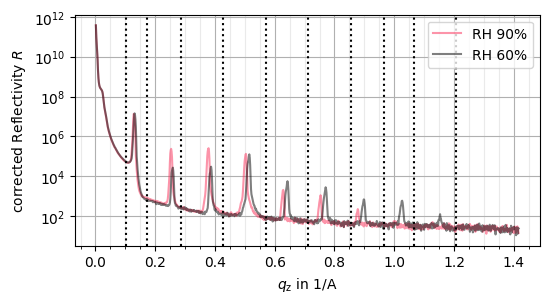

In [68]:
# plotting data (sanity check + period D determination)
RH = 90
RH_R_corr = RH_data_dict[f"RH{RH}"]["R_corr"]
RH_angle = RH_data_dict[f"RH{RH}"]["angle"]
RH_q_z = RH_data_dict[f"RH{RH}"]["q_z"]

RH_2 = 88
RH_3 = 60


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in 1/A')             # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'corrected Reflectivity $R$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"RH {RH}%")
# ax.semilogy(RH_data_dict[f"RH{RH_2}"]["q_z"], RH_data_dict[f"RH{RH_2}"]["R_corr"], color = "blue", alpha = 0.5, label = f"RH {RH_2}%")
ax.semilogy(RH_data_dict[f"RH{RH_3}"]["q_z"], RH_data_dict[f"RH{RH_3}"]["R_corr"], color = "black", alpha = 0.5, label = f"RH {RH_3}%")


# indizes for vertical marks for period D determination
q_z_index_list = [70, 120, 200, 300, 400, 500, 600, 680, 750, 850]

# plot xvlines 
for q_z_index in q_z_index_list:
    q_z = RH_q_z[q_z_index]
    ax.axvline(x = q_z, linestyle = "dotted", color = "black")

ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/corr_R_over_q_z.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/corr_R_over_q_z.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [ ]:
# determination of the maxima

# function to return (max_value_index, max_value) for a given array and start, end index
def get_max(array, start_i, end_i):
    max_index = start_i
    max_value = array[start_i]
    for i in range(start_i, end_i):
        if array[i] > max_value:
            max_index = i
            max_value = array[i]
    return (max_index, max_value)


# iterate through the RH values
for key in RH_data_dict:
    RH_R_corr = RH_data_dict[key]["R_corr"]
    q_z_array = RH_data_dict[key]["q_z"]

    # iterate through the q_z index checkmarks
    max_index_list = []
    max_q_z_list = []
    for i in range(len(1, q_z_index_list)):
        q_z_start_index = q_z_index_list[i-1]
        q_z_end_index = q_z_index_list[i]

        max_index, max_value = get_max(RH_R_corr, q_z_start_index, q_z_end_index)
        max_index_list.append(max_index)
        max_q_z_list.append(q_z_array[max_index])
    
    # save list of indices, and q_z_values of maximum peak values
    RH_data_dict[key]["q_z_max"] = max_q_z_list
    RH_data_dict[key]["index_max"] = max_index_list

    
# period determination